# Indicator Validation
This notebook is aimed at assisting developers with tracking large scale indicator changes beyond what can be picked up by the unit tests. While unit tests perform local sanity checks on the operations, the tests here will be more qualitative in nature, comparing the live version of an indicator with the propagating changes.

## Usage
Since each indicator will have different points of interest, this notebook will only provide a framework to get started. The goal is to support the comparison of the dataframes resulting from the data cleaning and shaping that our indicator code provides.

In [1]:
# Set your base directory (assuming this notebook is run from "covidcast_indicators/testing_utils/")
os.chdir("../")

%run testing_utils/indicator_validation.py

In [ ]:
# The above will likely cause an error due to missing dependencies, run this to fix
%%capture
!pip install pandas matplotlib joblib covidcast

## Installation
Install the utilities and the indicator you plan to test.

In [2]:
%%capture
os.chdir(join(ROOT_DIR, "_delphi_utils_python"))
!pip install -e .
os.chdir(join(ROOT_DIR, "jhu"))
!pip install -e .

## Run the indicator
If you are planning on testing your local receiving directory, you will need to generate those files. You can do that by running the cell below.

In [3]:
%%capture
os.chdir(join(ROOT_DIR, "jhu"))
!python -m delphi_jhu

## Qualitative Comparisons


### Loading Data
To load a local indicator and a remote `covidcast` indicator as dataframes for comparison use the function `load_signal_data(local_signal_dir, remote_signal_name, signal_type, start_day, end_day, geo_type)`. 

Separate functions for loading just the local and remote data exist as well. **Note that the local and remote values are cached to disk** to speed up computation and reduce API calls. See function docstring for instructions on clearing the cache.

In [2]:
local_signal_dir = "jhu"
remote_signal_name = "usa-facts"
signal_type = "confirmed_incidence_prop"
start_day = date(2020, 8, 1)
end_day = date.today()
geo_type = "state"

# load_local_signal_data.clear()
local_data, remote_data = load_signal_data(local_signal_dir, remote_signal_name, signal_type, start_day, end_day, geo_type)

### Comparing Geocode Signals
A simple plotting demo.

Total difference:  -0.18981468089412878


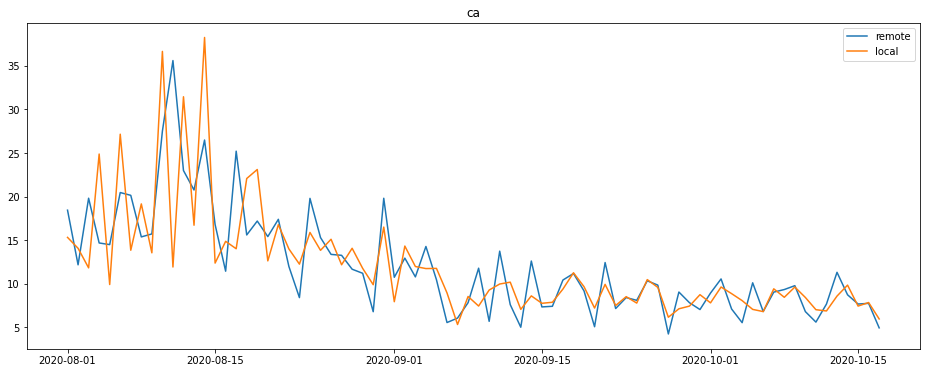

In [45]:
geo_code = "ca"
rd = remote_data.loc[geo_code, :]["value"]
ld = local_data.loc[geo_code, :]["val"]
plt.figure(figsize=(16, 6))
plt.plot(rd, label="remote")
plt.plot(ld, label="local")
plt.title(geo_code)
plt.legend()
print("Total difference: ", rd.sub(ld).sum())

## Automatically Detecting Outliers
Defining your own comparison statistics, we can automatically plot outlier signals.

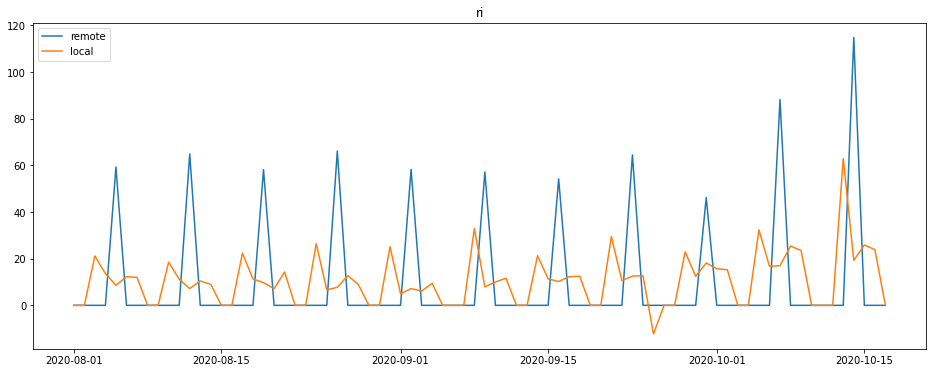

In [59]:
def simple_outlier_test(ld, rd):
    """
    Returns True if the rd and ld time series are similar, False otherwise.
    """
    max_percent_diff = rd.sub(ld).abs().max() / rd.abs().max()
    sum_percent_diff = rd.sub(ld).abs().sum() / rd.abs().sum()
    return False if max_percent_diff > 1.1 or sum_percent_diff > 1.1 else True

def plot_outliers(ld, rd, outlier_check):
    """
    Provides time series plots of geocodes that are sufficiently different.
    """
    local_geo_codes = set(local_data.reset_index()["geo_id"].unique())
    remote_geo_codes = set(remote_data.reset_index()["geo_value"].unique())
    geo_codes = local_geo_codes.intersection(remote_geo_codes)
    for geo_code in geo_codes:
        rd = remote_data.loc[geo_code, :]["value"]
        ld = local_data.loc[geo_code, :]["val"]
        if outlier_check(ld, rd) == False:
            plt.figure(figsize=(16, 6))
            plt.plot(rd, label="remote")
            plt.plot(ld, label="local")
            plt.title(geo_code)
            plt.legend()

plot_outliers(ld, rd, simple_outlier_test)